## Consistency

In [43]:
C = 8 # Minimo de periodos en la definicion de Consistency
minN = 30 # Minimo de periodos 

In [16]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from datetime import datetime
from dateutil import relativedelta
import warnings
warnings.filterwarnings('ignore')

In [27]:
df_panel = pd.read_csv(os.path.join('DATA', 'panel.csv'))
df_panel.drop(columns=['Unnamed: 0', 'gvkey', 'hscode6'], inplace=True)
df_panel["gvkey_hscode6_date"] = df_panel['gvkey_hscode6'].astype(str) +"_"+ df_panel["date"].astype(str)
print(df_panel.shape)
df_panel.head()

(173204, 19)


,date,code2,vol,gvkey_hscode6,month,quarter,period,1,2,3,4,vol_log,period_log,vol_log_hat,R,sigmaR,source1,vol%,gvkey_hscode6_date
0,2010-01-01,87,14.00,1300_870323,1,1,4,1,0,0,0,3.906891,2.321928,2.629608,1.277283,0.000000,China,100.0,1300_870323_2010-01-01
1,2010-04-01,87,10.00,1300_870323,4,2,5,0,1,0,0,3.459432,2.584963,2.271375,1.188057,0.616335,China,100.0,1300_870323_2010-04-01
2,2011-01-01,87,0.82,1300_870323,1,1,8,1,0,0,0,0.863938,3.169925,2.272843,-1.408904,0.352145,China,100.0,1300_870323_2011-01-01
3,2011-04-01,87,1.79,1300_870323,4,2,9,0,1,0,0,1.480265,3.321928,1.961322,-0.481057,0.215767,China,100.0,1300_870323_2011-04-01
4,2011-07-01,87,3.21,1300_870323,7,3,10,0,0,1,0,2.073820,3.459432,2.578809,-0.504989,0.452585,China,100.0,1300_870323_2011-07-01


In [ ]:
# # ['Hong Kong', 'Taiwan'] == 'China'
# df_source1.loc[df_source1['source1'] == "Taiwan", 'source1'] = 'China'
# df_source1.loc[df_source1['source1'] == "Hong Kong", 'source1'] = 'China'

In [31]:
df_source1 = pd.read_csv(os.path.join('DATA', 'panel_source1.csv'))
df_source1.drop(columns=['Unnamed: 0'], inplace=True)
df_source1["gvkey_hscode6_date"] = df_source1['gvkey_hscode6'].astype(str) +"_"+ df_source1["date"].astype(str)
df_source1 = df_source1[df_source1['gvkey_hscode6_date'].isin(df_panel["gvkey_hscode6_date"])]
print(df_source1.shape)
df_source1.head()

(514305, 4)


,date,source1,gvkey_hscode6,gvkey_hscode6_date
3,2010-01-01,Hong Kong,1045_940360,1045_940360_2010-01-01
4,2010-10-01,Indonesia,1045_940360,1045_940360_2010-10-01
5,2011-01-01,Indonesia,1045_940360,1045_940360_2011-01-01
6,2011-04-01,Indonesia,1045_940360,1045_940360_2011-04-01
7,2011-07-01,Indonesia,1045_940360,1045_940360_2011-07-01


In [32]:
df_country = pd.read_csv(os.path.join('DATA', 'panel_countries.csv'))
df_country.drop(columns=['Unnamed: 0'], inplace=True)
df_country["gvkey_hscode6_date"] = df_country['gvkey_hscode6'].astype(str) +"_"+ df_country["date"].astype(str)
df_country = df_country[df_country['gvkey_hscode6_date'].isin(df_country["gvkey_hscode6_date"])]
print(df_country.shape)
df_country.head()

(395914, 9)


,gvkey,date,country,hscode6,code2,gvkey_hscode6,vol,vol%,gvkey_hscode6_date
0,1045,2009-01-01,Indonesia,940360,94,1045_940360,5.00,100.0,1045_940360_2009-01-01
1,1045,2009-04-01,United Kingdom,940360,94,1045_940360,0.55,100.0,1045_940360_2009-04-01
2,1045,2009-07-01,China,940360,94,1045_940360,2.00,100.0,1045_940360_2009-07-01
3,1045,2010-01-01,China,940360,94,1045_940360,2.00,100.0,1045_940360_2010-01-01
4,1045,2010-10-01,Indonesia,940360,94,1045_940360,2.00,100.0,1045_940360_2010-10-01


In [63]:
def addSN_minN(df_panel, minN=30):
    '''
    Add columns N and S que asigna a cada gvkey_hscode6:
    N: Numero de periodos observados con importaciones.
    S: Numero de Sources (paises) distintos.
    
    Deja solo los gvkey_hscode6 con >=minN periods.
    '''    
    
    # cantidad de periodos observados   
    df_N = df_source1[['gvkey_hscode6', 'date']].groupby('gvkey_hscode6').count()
    df_N.rename(columns={'date': 'N'}, inplace=True)
    
    # cantidad de paises
    df_S = pd.DataFrame(df_source1[['gvkey_hscode6', 'source1']].groupby('gvkey_hscode6')['source1'].nunique())
    df_S.rename(columns={'source1': 'S'}, inplace=True)
    
    df_SN = pd.concat([df_S, df_N], axis='columns')
    
    df_minN = df_SN[df_SN['N']>=minN].copy()
    df_minN = df_minN.reset_index()

    
    df_source1_minN = df_source1[df_source1['gvkey_hscode6'].isin(df_minN['gvkey_hscode6'])]
    df_source1_minN['S'] = df_source1_minN['gvkey_hscode6'].map(df_minN.set_index('gvkey_hscode6')[['S', 'N']].to_dict()['S'])
    df_source1_minN['N'] = df_source1_minN['gvkey_hscode6'].map(df_minN.set_index('gvkey_hscode6')[['S', 'N']].to_dict()['N'])
    df_source1_minN.drop(columns=['date', 'source1','gvkey_hscode6' ], inplace=True)
    df_source1_minN.drop_duplicates(inplace=True)
    
#     df = df_panel[df_panel['gvkey_hscode6'].isin(list(df_source1_minN['gvkey_hscode6'].unique()))].copy()
    df = pd.concat([df_panel.set_index(['gvkey_hscode6_date']), df_source1_minN.set_index(['gvkey_hscode6_date'])], axis='columns')
    df = df.sort_values(by=['gvkey_hscode6', 'date'])
    df.reset_index(inplace=True)

    return df

In [65]:
def get_antes_despues(df_panel, gvhs):
    df = df_panel[df_panel['gvkey_hscode6']==gvhs].copy()
    df = df.sort_values(by=['date'])
    df = df[['gvkey_hscode6', 'date', 'source1']]

    source1 = list(df['source1'].copy())

    def despues(i):
        j=1
        source_list = source1[i+1:].copy()
        for c in source_list:
            if source1[i]!=c: break
            j=j+1
        return j

    def antes(i):
        j=1
        source_list = source1[:i].copy()
        source_list.reverse()
        for c in source_list:
            if source1[i]!=c: break
            j=j+1
        return j
    
    def cambio(i):
        if i==0: j=0

    df['despues'] = [despues(i) for i, x in enumerate(source1)]
    df['antes'] = [antes(i) for i, x in enumerate(source1)]
    
    return df

In [67]:
def add_antes_despues(df_panel):
    '''
    Genera columnas: antes despues
    para cada row ('gvkey_hscode6', 'date', 'source1'), 
    cuenta el numero de date consecutivos con el mismo source1 con fecha ANTERIOR (antes).
    cuenta el numero de date consecutivos con el mismo source1 con fecha POSTERIOR (despues).
    '''
    df = pd.DataFrame()
    for gvhs in tqdm(df_panel['gvkey_hscode6'].unique()):
        df_ = get_antes_despues(df_panel, gvhs)
        df = df.append(df_)

    df.drop(columns=['source1'], inplace=True)

    df_panel = pd.concat([df_panel.set_index(['gvkey_hscode6', 'date']), df.set_index(['gvkey_hscode6', 'date'])], axis='columns')
    df_panel = df_panel.sort_values(by=['gvkey_hscode6', 'date'])
    df_panel.reset_index(inplace=True)
    return df_panel

In [68]:
%%time
df_panel = add_antes_despues(df_panel)
df_panel.head()

100%|██████████████████████████████████████████████████████████████████████████████| 5065/5065 [00:55<00:00, 91.79it/s]


Wall time: 55.5 s


,gvkey_hscode6,date,gvkey_hscode6_date,code2,vol,month,quarter,period,1,2,...,period_log,vol_log_hat,R,sigmaR,source1,vol%,S,N,despues,antes
0,10000_850440,2010-01-01,10000_850440_2010-01-01,85,2.16,1,1,4,1,0,...,2.321928,1.777965,-0.118040,0.000000,Saint Kitts and Nevis,92.592593,6.0,71.0,10,1
1,10000_850440,2010-04-01,10000_850440_2010-04-01,85,2.19,4,2,5,0,1,...,2.584963,2.225620,-0.552064,0.167526,Saint Kitts and Nevis,91.324201,6.0,71.0,9,2
2,10000_850440,2010-07-01,10000_850440_2010-07-01,85,1.18,7,3,6,0,0,...,2.807355,1.479205,-0.354877,0.341660,Saint Kitts and Nevis,84.745763,6.0,71.0,8,3
3,10000_850440,2010-10-01,10000_850440_2010-10-01,85,4.00,10,4,7,0,0,...,3.000000,1.948614,0.373315,0.244375,Saint Kitts and Nevis,100.000000,6.0,71.0,7,4
4,10000_850440,2011-01-01,10000_850440_2011-01-01,85,3.16,1,1,8,1,0,...,3.169925,1.512157,0.544426,0.004050,Saint Kitts and Nevis,94.936709,6.0,71.0,6,5


In [71]:
def add_consistency(df_panel, C):
    '''
    Genera columna: consistency
    para cada unit ('gvkey_hscode6' 'date'), C=1 if la data esta dentro de una Consistency. 
    seguidos de la misma source1.  
    ''' 
    
    def get_consistency(df, C):
        despues = df.loc[:, 'despues'].copy()
        consistency = []
        despues_iter = iter(despues)

        for x in despues_iter:
            if x>=C: 
                consistency.extend([1]*int(x))
                for i in range(int(x)-1): next(despues_iter)   
            else: 
                consistency.extend([0])

        df['consistency_' + str(C)] = consistency
        return df


    def add_consistency_panel(df_panel, C):
        df = pd.DataFrame()
        list_gvkey_hscode6 = list(df_panel['gvkey_hscode6'].unique())

        for gvkey_hscode6 in tqdm(list_gvkey_hscode6):
            df_ = df_panel[df_panel['gvkey_hscode6']==gvkey_hscode6]
            df_ = get_consistency(df_, C)
            df = df.append(df_)
        return df
    
    
    df = df_panel.copy()
    df = add_consistency_panel(df, C)
    
    # agrego una columna 'C' que es igual a consistency
    df['C'] = df[df.columns[df.columns.str.startswith('consistency')][0]]

    return df

In [72]:
%%time
df_consistency = add_consistency(df_panel, C)
print(df_consistency.shape)
df_consistency.head(3)

100%|██████████████████████████████████████████████████████████████████████████████| 5065/5065 [03:14<00:00, 26.10it/s]

(173204, 25)
Wall time: 3min 14s


,gvkey_hscode6,date,gvkey_hscode6_date,code2,vol,month,quarter,period,1,2,...,R,sigmaR,source1,vol%,S,N,despues,antes,consistency_8,C
0,10000_850440,2010-01-01,10000_850440_2010-01-01,85,2.16,1,1,4,1,0,...,-0.118040,0.000000,Saint Kitts and Nevis,92.592593,6.0,71.0,10,1,1,1
1,10000_850440,2010-04-01,10000_850440_2010-04-01,85,2.19,4,2,5,0,1,...,-0.552064,0.167526,Saint Kitts and Nevis,91.324201,6.0,71.0,9,2,1,1
2,10000_850440,2010-07-01,10000_850440_2010-07-01,85,1.18,7,3,6,0,0,...,-0.354877,0.341660,Saint Kitts and Nevis,84.745763,6.0,71.0,8,3,1,1


In [73]:
df_consistency.to_csv(os.path.join('DATA', 'panel_consistency.csv'))

In [74]:
df_panel = pd.read_csv(os.path.join('DATA', 'panel_consistency.csv'))
df_panel.drop(columns=['Unnamed: 0', 'consistency_8'], inplace=True)
print(df_panel.shape)
df_panel.head(3)

(173204, 24)


,gvkey_hscode6,date,gvkey_hscode6_date,code2,vol,month,quarter,period,1,2,...,vol_log_hat,R,sigmaR,source1,vol%,S,N,despues,antes,C
0,10000_850440,2010-01-01,10000_850440_2010-01-01,85,2.16,1,1,4,1,0,...,1.777965,-0.118040,0.000000,Saint Kitts and Nevis,92.592593,6.0,71.0,10,1,1
1,10000_850440,2010-04-01,10000_850440_2010-04-01,85,2.19,4,2,5,0,1,...,2.225620,-0.552064,0.167526,Saint Kitts and Nevis,91.324201,6.0,71.0,9,2,1
2,10000_850440,2010-07-01,10000_850440_2010-07-01,85,1.18,7,3,6,0,0,...,1.479205,-0.354877,0.341660,Saint Kitts and Nevis,84.745763,6.0,71.0,8,3,1


In [75]:
def get_N():
    df = df_panel[df_panel['C']==1][['gvkey_hscode6', 'source1']].groupby(['gvkey_hscode6']).nunique()
    df.reset_index(inplace=True)
    df.rename(columns={'source1': 'N'}, inplace=True)
    dictio = {gvhs: n for gvhs, n in zip(df['gvkey_hscode6'], df['N'])}

    N = dict()
    N[1] = list(df['gvkey_hscode6'][df['N']==1].unique())
    N[2] = list(df['gvkey_hscode6'][df['N']==2].unique())
    N[3] = list(df['gvkey_hscode6'][df['N']==3].unique())
    N[4] = list(df['gvkey_hscode6'][df['N']==4].unique())
    N[5] = list(df['gvkey_hscode6'][df['N']==5].unique())
    N[0] = list(set(df_panel['gvkey_hscode6'].unique()).difference(set(N[1])).difference(set(N[2])).difference(set(N[3])).difference(set(N[4])).difference(set(N[5])))

    return N

In [76]:
N = get_N()

In [77]:
print(len(N[0]), len(N[1]), len(N[2]), len(N[3]), len(N[4]), len(N[5]))

735 4094 233 3 0 0


In [78]:
len(N[0]) + len(N[1]) + len(N[2]) + len(N[3]) + len(N[4]) + len(N[5])

5065

In [79]:
len(df_panel['gvkey_hscode6'].unique())

5065

In [80]:
def gen_df_source12():
    '''
    Genera columna: consistency
    para cada ('gvkey_hscode6' 'date'), consistency=1 if la data esta dentro de un periodo de imports >=C 
    seguidos de la misma source1.  
    '''  

    # lista de units con 2 Consistency de distinto country
    lista = []
    for gvkey in N[2]:
        df = df_panel[df_panel['gvkey_hscode6']==gvkey].copy()
        sources = list(df[df['C']==1]['source1'].unique())
        if len(sources)==1: continue
        lista.append(gvkey)

    df_panel2 = df_panel[np.logical_and(df_panel['gvkey_hscode6'].isin(N[2]), df_panel['C']==1)].copy()

    df = df_panel2[['gvkey_hscode6', 'source1', 'date']].groupby(['gvkey_hscode6', 'source1']).first()
    df.reset_index(inplace=True)
    df_source1 = df[['gvkey_hscode6', 'source1']].copy()

    dictio = dict()
    for gv_hs in df_source1['gvkey_hscode6'].unique():
        country = list(df_source1[df_source1['gvkey_hscode6']==gv_hs]['source1'])
        dates1 = list(df_panel2[np.logical_and(df_panel2['gvkey_hscode6']==gv_hs, df_panel2['source1']==country[0])]['date'].copy())
        dates2 = list(df_panel2[np.logical_and(df_panel2['gvkey_hscode6']==gv_hs, df_panel2['source1']==country[1])]['date'].copy())
        if dates1[-1] < dates2[0]: dictio[gv_hs] = [country[0], country[1]]
        if dates1[0] > dates2[-1]: dictio[gv_hs] = [country[1], country[0]]

    df = pd.DataFrame()
    df['gvkey_hscode6'] = dictio.keys()
    df['source1'] = [lista[0] for lista in dictio.values()]
    df['source2'] = [lista[1] for lista in dictio.values()]
    
    return df

In [81]:
%%time
df_source12 = gen_df_source12()
print(df_source12.shape)
df_source12.head()

(226, 3)
Wall time: 2.05 s


,gvkey_hscode6,source1,source2
0,102523_851290,Denmark,China
1,102523_851629,Germany,Ireland
2,102523_854430,China,Japan
3,10275_853210,India,China
4,10443_870880,Argentina,China


In [ ]:
# df_panel['I'] = 0
# for index, row in df_source12[df_source12['source1']=='China'].iterrows():
#     df_panel.loc[np.logical_and(df_panel["gvkey_hscode6"]==row['gvkey_hscode6'], df_panel["source1"]=='China'), 'I'] = 1
# df_panel['I'] = df_panel['I'] * df_panel['C']

In [82]:
df_panel['I'] = 0
df_panel.loc[df_panel["source1"]=='China', 'I'] = 1

In [83]:
df_panel[['gvkey', 'hscode6']] = df_panel['gvkey_hscode6'].str.split("_", expand=True)

In [84]:
df_panel.to_csv(os.path.join('DATA', 'df_panel__.csv'))

<AxesSubplot:xlabel='date'>

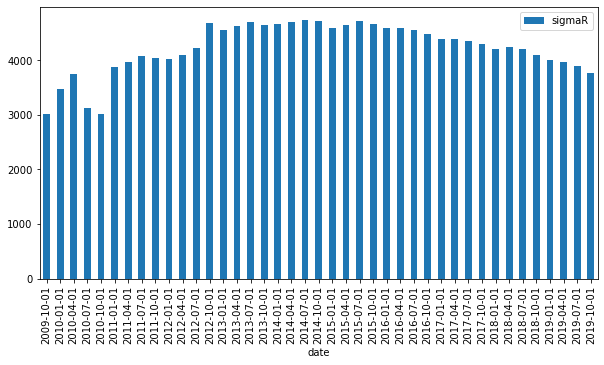

In [85]:
df_panel[['date', 'sigmaR']].groupby('date').count().plot(kind='bar', figsize=(10,5))

<AxesSubplot:xlabel='date'>

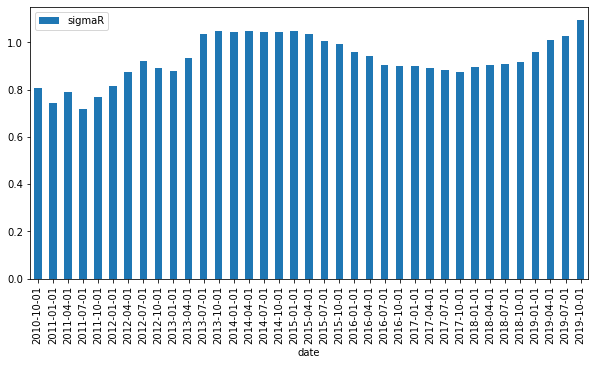

In [88]:
df_panel[['date', 'sigmaR']].groupby('date').mean()[4:].plot(kind='bar', figsize=(10,5))

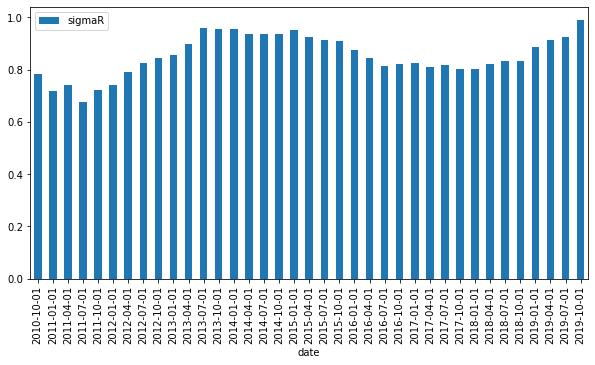

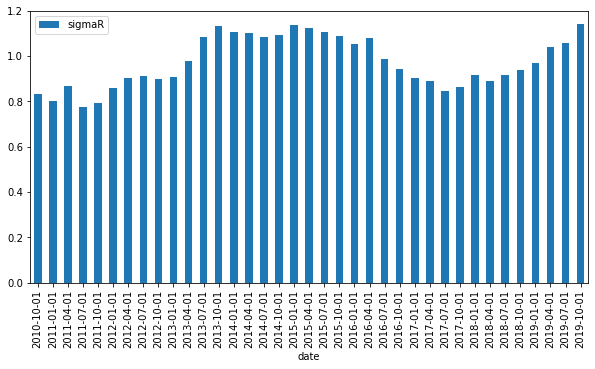

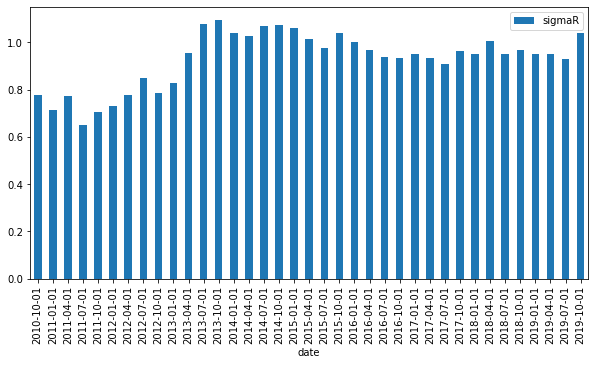

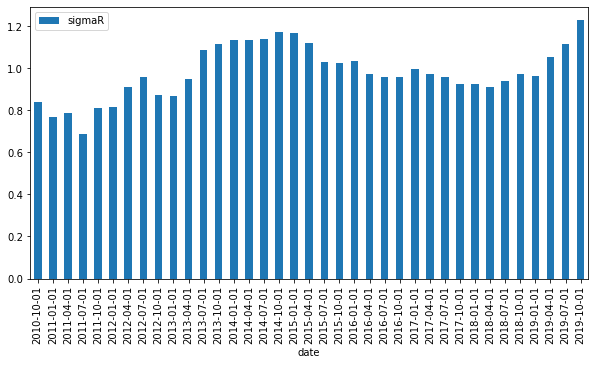

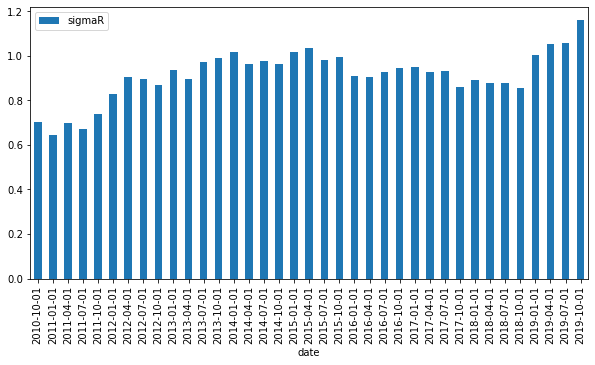

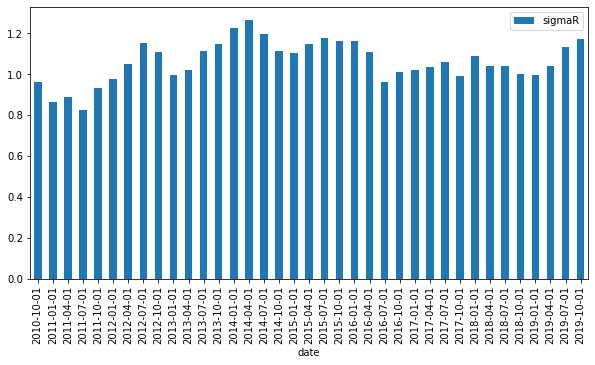

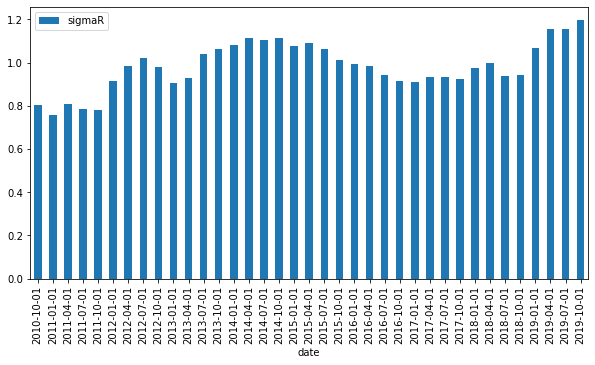

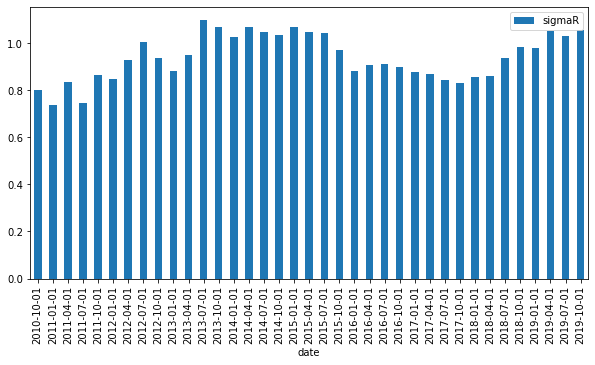

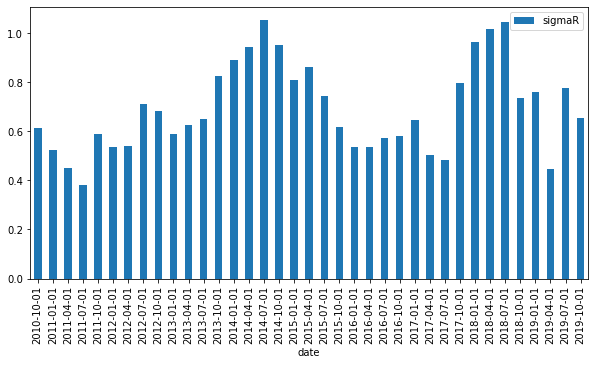

In [89]:
for code2 in df_panel['code2'].unique():
    df_panel[['date', 'sigmaR']][df_panel['code2']==code2].groupby('date').mean()[4:].plot(kind='bar', figsize=(10,5))

In [90]:
j = '11672_940520'

In [95]:
df_panel[df_panel['gvkey_hscode6']==j]['vol%']

18065     79.518072
18066    100.000000
18067    100.000000
18068    100.000000
18069     80.645161
18070    100.000000
18071    100.000000
18072    100.000000
18073    100.000000
18074    100.000000
18075    100.000000
18076     86.887509
18077     36.708861
18078     65.005028
18079     57.977528
18080     51.846877
18081     61.028730
18082     64.841499
18083     72.098214
18084     93.094089
18085     87.172076
18086     85.198797
18087     81.929379
18088     89.603188
18089    100.000000
18090    100.000000
18091    100.000000
18092    100.000000
18093    100.000000
18094    100.000000
18095     96.948959
18096    100.000000
Name: vol%, dtype: float64